## Fisher Matrix

Use a numerical approximation to calculate the Fisher Matrix given a redshift, chirp mass, and eta value.

In [9]:
from __future__ import division

import numpy as np

import sys
sys.path.append('/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/')
import lal
import lalsimulation
from lalinference.rapid_pe import lalsimutils
import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
import astropy
from astropy import cosmology


In [144]:
def generate_waveform(m_chirp, eta, redshift, delta_f, flow, fmax, 
                      approx=lalsimulation.IMRPhenomPv2, both=True):
    
    """
    Generate a waveform given a chirp mass and symmetric mass ratio
    for binaries with zero spin.
    
    m_chirp -- chirp mass in solar masses
    
    eta -- float symmetric mass ratio
    
    redshift -- float redshift value
    
    delta_f -- frequency step size in Hz
    
    flow -- minimum frequency in Hz
    
    fmax -- maximum frequency in Hz
    
    approx -- waveform approximant (i.e. lalsimulation.IMRPhenomPv2)
    
    both -- Boolean dictating the summation of h_plus and h_cross
    
    Returns:
    h1 -- magnitude of h_plus and h_cross in the frequency domain
    """
    
    # Generate a waveform following the same procedure in waveform_overlap.ipynb
    m1, m2 = lalsimutils.m1m2(m_chirp, eta)
    m1 *= lal.MSUN_SI
    m2 *= lal.MSUN_SI
    s1x, s1y, s1z = 0.0, 0.0, 0.0
    s2x, s2y, s2z = 0.0, 0.0, 0.0
    coa_phase, polarization_angle = 0.0, 0.0
    ra, dec = 0.0, 0.0
    dist = cosmology.Planck15.comoving_distance(redshift).value * lal.PC_SI * 1e6
    incl = 0.0

    hpf, hxf = lalsimulation.SimInspiralFD(coa_phase, delta_f,
                                m1, m2,
                                s1x, s1y, s1z,
                                s2x, s2y, s2z,
                                flow, fmax, flow,
                                dist, redshift, incl,
                                0.0, 0.0, None, None,
                                0, -1, approx)
   
    # For convenience, we'll reuse hpf and redefine to be h1
    if both:
        hpf.data.data += hxf.data.data
        
    h1 = hpf
    return h1.data.data

In [158]:
def deriv_chirp_mass(m_chirp, eta, redshift, df, flow, fhigh):
    
    """
    Find the partial derivative of h(f) with respect to chirp mass.
    
    m_chirp -- chirp mass in solar masses
    
    eta -- symmetric mass ratio
    
    redshift -- redshift value
    
    df -- frequency step size in Hz
    
    flow -- minimum frequency in Hz
    
    fhigh -- maximum frequency in Hz
    
    Returns:
    Array of partial derivative of h(f) with respect to chirp mass for various frequencies
    """
    
    derivs = []
    
    # Calculate the waveform h(f) at this given parameter set
    waveform_orig = generate_waveform(m_chirp, eta, redshift, df, flow, fhigh)
    
    # Find the h(f) for a chirp mass very close to the original chirp mass
    delta_mc = 0.001  # Solar Masses
    waveform_changed = generate_waveform(m_chirp + delta_mc, eta, redshift, df, flow, fhigh)
    
    # Clip off h(f) values corresponding to frequencies before flow -- !!! CHECK THIS
    flow_index = int(flow/df)
    waveform_orig = waveform_orig[flow_index:]
    waveform_changed = waveform_changed[flow_index:]
    # I'm concerned that I'm actually cutting off high values, not low values
   
    # Calculate the derivative for each frequency value
    for index, value in enumerate(waveform_orig):
        derivs.append((waveform_changed[index] - value) / delta_mc) # !!! - CHECK THIS: is the division ok?
    
    return np.asarray(derivs)



def deriv_eta(m_chirp, eta, redshift, df, flow, fhigh):
    
    """
    Find the partial derivative of h(f) with respect to eta.
    
    m_chirp -- chirp mass in solar masses
    
    eta -- symmetric mass ratio
    
    redshift -- redshift value
    
    df -- frequency step size in Hz
    
    flow -- minimum frequency in Hz
    
    fhigh -- maximum frequency in Hz
    
    Returns:
    Array of partial derivative of h(f) with respect to eta for various frequencies
    """
    
    derivs = []
    
    # Calculate the waveform h(f) at this given parameter set
    waveform_orig = generate_waveform(m_chirp, eta, redshift, df, flow, fhigh)
    
    # Find the h(f) for a eta very close to the original eta
    delta_eta = 0.001  # Solar Masses
    waveform_changed = generate_waveform(m_chirp, eta + delta_eta, redshift, df, flow, fhigh)
    
    # Clip off h(f) values corresponding to frequencies before flow -- !!! CHECK THIS
    flow_index = int(flow/df)
    waveform_orig = waveform_orig[flow_index:]
    waveform_changed = waveform_changed[flow_index:]
    # I'm concerned that I'm actually cutting off high values, not low values
   
    # Calculate the derivative for each frequency value
    for index, value in enumerate(waveform_orig):
        derivs.append((waveform_changed[index] - value) )#/ delta_eta) # !!! - CHECK THIS: is the division ok?
    
    return np.asarray(derivs)
    
    

In [159]:
def find_fisher_matrix(m_chirp, eta, redshift, df):
    
    """
    Calculate a Fisher Matrix given a set of masses, redshifts, and frequency values.
    
    We assume a minimum frequency value of 30 Hz and a maximum of 2048 Hz.
    
    m_chirp -- chirp mass in solar mass
    
    eta -- symmetric mass ratio
    
    redshift -- redshift value
    
    df -- spacing between discretely sampled frequency values
    
    Returns:
    FM -- 2-by-2 matrix for fisher information matrix using chirp mass and eta derivatives
    
    """
    
    # Set frequency range
    flow = 30  # Hz
    fhigh = 2048  # Hz
    freqs = np.arange(flow, fhigh + df, df)
    
    # Find PSD at given frequency values
    psd = map(lalsimulation.SimNoisePSDaLIGOZeroDetHighPower, freqs)
    
    # Calculate the partial of h(f) with respect to chirp mass
    dMc = deriv_chirp_mass(m_chirp, eta, redshift, df, flow, fhigh)
    
    # Calculate the partial of h(f) with respect to eta
    dEta = deriv_eta(m_chirp, eta, redshift, df, flow, fhigh)

    # Find elements of the Fisher matrix
    v1 = 4*np.real(np.sum(dMc*np.conjugate(dMc) / psd * df))
    v2 = 4*np.real(np.sum(dMc*np.conjugate(dEta) / psd * df))
    v3 = 4*np.real(np.sum(dEta*np.conjugate(dMc) / psd * df))
    v4 = 4*np.real(np.sum(dEta*np.conjugate(dEta) / psd * df))
    
    # construct Fisher matrix
    #FM = np.matrix([[v1,v2], [v3,v4]])
    FM = v1
    
    return FM


In [167]:
FM = find_fisher_matrix(2., 0.24, 0.001, 1./32)
print '1D Fisher Matrix:', FM
print 'Standard Deviation:', np.sqrt(1/FM)

 1D Fisher Matrix: 1.64154676036e+12
Standard Deviation: 7.80500832849e-07


In [174]:
chirp_masses = np.linspace(1,30,31)
fisher = []
stdev = []
for chirp_mass in chirp_masses:
    FM = find_fisher_matrix(chirp_mass, 0.2, 0.2, 1./32)
    fisher.append(FM)
    stdev.append(np.sqrt(1/FM))


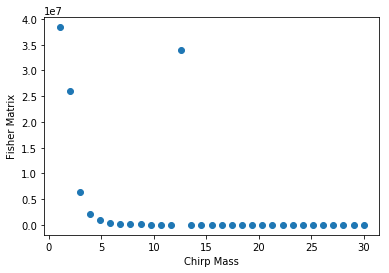

In [172]:
plt.figure(1)
plt.scatter(chirp_masses, np.asarray(fisher))
plt.xlabel('Chirp Mass')
plt.ylabel('Fisher Matrix')
plt.show()

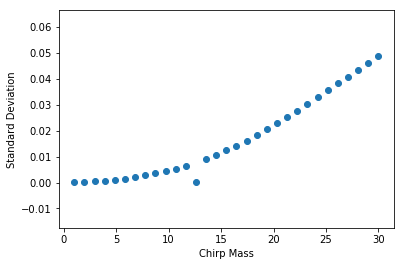

In [173]:
plt.figure(1)
plt.scatter(chirp_masses, np.asarray(stdev))
plt.xlabel('Chirp Mass')
plt.ylabel('Standard Deviation')
plt.show()